In [1]:
import numpy as np
from pyproj import Proj, transform
from scipy import interpolate, signal

import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

fn = "D:\\crs\\proj\\2019_DorianOBX\\NCEI_gridded_bathy\\morehead_city_13_navd88_2011.nc"
ds = xr.open_dataset(fn)

In [2]:
lat = ds.lat.values
lon = ds.lon.values
za  = ds.Band1.values
print(np.shape(lat),np.shape(lon),np.shape(za))

(12961,) (13717,) (12961, 13717)


In [3]:
ilat = np.where(lat>=34.8)[0][0]
llat = np.where(lat<=35.1)[0][-1]
ilon = np.where(lon>=-76.35)[0][0]
llon = np.where(lon<=-76.0)[0][-1]

print(ilat,llat)
print(ilon,llon)

slat = lat[ilat:llat]
slon = lon[ilon:llon]
X, Y = np.meshgrid(slon,slat)

4644 7884
9937 13716


In [4]:
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:26918')

x,y=transform(inProj,outProj,X,Y)

(12961, 13717)


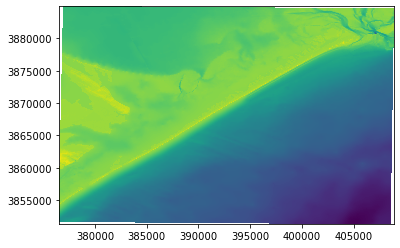

In [5]:
z = za[ilat:llat,ilon:llon]
print(np.shape(za))
plt.pcolormesh(x,y,z)

In [6]:
fdir = "D:/crs/proj/2019_DorianOBX/WayneWright_flights/"

fnames = (\
          "post_Matthew_lidar_1m.tif",\
          "2019-08-30_1m_DEM_v1_crop.tif",\
          "2019-09-12-13_DEM_1m_v1_crop.tif")

titles = ([\
         "post-Matthew",\
         "pre-Dorian",\
         "post-Dorian"])

nf = len(fnames)

# optional median-filter smoothing of original maps
smooth = False
# kernal size...this should be an odd number >= dxy/0.1
ksize = 3

In [7]:
def box2UTMh(x, y, x0, y0, theta):
    '''
    2D rotation and translation of x, y
    Input:
        x, y - row vectors of original coordinates (must be same size)
        x0, y0 - Offset (location of x, y = (0,0) in new coordinate system)
        theta - Angle of rotation (degrees, CCW from x-axis == Cartesian coorinates)
    Returns:
        xr, yr - rotated, offset coordinates
    '''
    thetar = np.radians(theta)
    c, s = np.cos(thetar), np.sin(thetar)

    # homogenous rotation matrix
    Rh = np.array(((c, -s,  0.),\
                   (s,  c,  0.),\
                   (0., 0., 1.)))
    # homogenous translation matrix
    Th = np.array(((1., 0., x0),\
                   (0., 1., y0),\
                   (0., 0., 1.)))
    
    # homogenous input x,y
    xyh = np.vstack((x,y,np.ones_like(x)))

    # perform rotation and translation
    xyrh=np.matmul(np.matmul(Th,Rh),xyh)
    xr = xyrh[0,:]
    yr = xyrh[1,:]
    return xr, yr

In [8]:
def map_stats(mp):
    '''
    Calculate some basic statistics for 3D map arrays
    '''
    mean = np.nanmean(mp,axis=(1,2))
    mad = np.nanmean(np.abs(mp),axis=(1,2))
    dmin = np.nanmin(mp,axis=(1,2))
    dmax = np.nanmax(mp,axis=(1,2))
    rms = np.sqrt(np.nanmean(mp**2.,axis=(1,2)))
    s = np.shape(mp)
    num = []
    numn = []
    for i in range(s[0]):
       num.append(mp[i,:,:].size)
       numn.append(np.count_nonzero(np.isnan(mp[i,:,:])))
    print("Shape: ",s)
    print("mean",mean)
    print("mad",mad)
    print("min",dmin)
    print("max",dmax)
    print("rms",rms)
    print("nans",numn)
    print("size",num)
    return mean, mad

In [9]:
# make a small box w/ cell centered grid with spacing dxy
dxy = 1.
xmax = 1200. # alongshore
ymax = 700.  # cross-shore
nx = int((1./dxy)*xmax)
ny = int((1./dxy)*ymax)

xcoords = np.linspace(0.5*dxy,xmax-0.5*dxy,nx)
ycoords = np.linspace(0.5*dxy,ymax-0.5*dxy,ny)
# Y is ascending
xrot, yrot=np.meshgrid(xcoords, ycoords ,sparse=False, indexing='xy')
print("xrot:")
print(xrot.shape)
print(xrot)
print("yrot:")
print(yrot.shape)
print(yrot)

xrot:
(700, 1200)
[[5.0000e-01 1.5000e+00 2.5000e+00 ... 1.1975e+03 1.1985e+03 1.1995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.1975e+03 1.1985e+03 1.1995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.1975e+03 1.1985e+03 1.1995e+03]
 ...
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.1975e+03 1.1985e+03 1.1995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.1975e+03 1.1985e+03 1.1995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.1975e+03 1.1985e+03 1.1995e+03]]
yrot:
(700, 1200)
[[5.000e-01 5.000e-01 5.000e-01 ... 5.000e-01 5.000e-01 5.000e-01]
 [1.500e+00 1.500e+00 1.500e+00 ... 1.500e+00 1.500e+00 1.500e+00]
 [2.500e+00 2.500e+00 2.500e+00 ... 2.500e+00 2.500e+00 2.500e+00]
 ...
 [6.975e+02 6.975e+02 6.975e+02 ... 6.975e+02 6.975e+02 6.975e+02]
 [6.985e+02 6.985e+02 6.985e+02 ... 6.985e+02 6.985e+02 6.985e+02]
 [6.995e+02 6.995e+02 6.995e+02 ... 6.995e+02 6.995e+02 6.995e+02]]


In [10]:
# Define the ROI with bottom left corner and rotation of axes
#e0 = 391210.; n0 = 3868600.
e0 = 391460.; n0 = 3868410. # first analysis
e0 = 386485.; n0 = 3863430. # model grid point


rot = 44.

print('Shape of xrot, yrot: ',np.shape(xrot),np.shape(xrot))
shp = np.shape(xrot)
xu, yu = box2UTMh(xrot.flatten(), yrot.flatten(), e0, n0, rot)
xu=np.reshape(xu,shp)
yu=np.reshape(yu,shp)
print('Shape of xu and yu: ',np.shape(xu),np.shape(yu))

Shape of xrot, yrot:  (700, 1200) (700, 1200)
Shape of xu and yu:  (700, 1200) (700, 1200)


In [11]:
# write the UTM coords of the corners to an ASCII file
corners = np.asarray(  [[xu[0][0],yu[0][0]],\
                       [xu[0][-1],yu[0][-1]],\
                       [xu[-1][-1],yu[-1][-1]],\
                       [xu[-1][0],yu[-1][0]],\
                       [xu[0][0],yu[0][0]]])

corners
np.savetxt("corners.csv", corners, delimiter=",")

In [12]:
%%time

dslist=[]
for i in range(nf):
    fn = fdir+fnames[i]
    print(i, fn)
    
    # open the tif with XArray as a DataArray
    da = xr.open_rasterio(fn)
    
    print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )
    x = da['x'].values
    y = np.flipud(da['y'].values)
    
    # Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
    # However, make sure to squeeze before flipping
    z = np.flipud(np.squeeze(da.values))
    print(np.shape(x),np.shape(y),np.shape(z))
    

    if(smooth):
        # smooth with 2D running median
        zs = signal.medfilt2d(z, kernel_size=ksize)
    else:
        zs = z
    
    f = interpolate.RegularGridInterpolator( (y, x), zs, method='linear')   
    
    # Array for interpolated elevations
    zi=np.NaN*np.ones((ny,nx))

    # this is a slow iteration through all of the points, but allows us to skip ones that are outside
    for ij in np.ndindex(zi.shape):
        try:
            zi[ij]=f((yu[ij],xu[ij]))
        except:
            zi[ij]=np.NaN
            
    da = xr.DataArray(zi,dims=['Alongshore','Cross-shore'],coords={'Alongshore': ycoords, 'Cross-shore':xcoords })
    da = da.chunk()
    dslist.append(da)

dsa = xr.concat(dslist, dim='map')

0 D:/crs/proj/2019_DorianOBX/WayneWright_flights/post_Matthew_lidar_1m.tif
(34727,) (38113,) (1, 34727, 38113)
(38113,) (34727,) (34727, 38113)
1 D:/crs/proj/2019_DorianOBX/WayneWright_flights/2019-08-30_1m_DEM_v1_crop.tif
(22393,) (25165,) (1, 22393, 25165)
(25165,) (22393,) (22393, 25165)
2 D:/crs/proj/2019_DorianOBX/WayneWright_flights/2019-09-12-13_DEM_1m_v1_crop.tif
(22101,) (25420,) (1, 22101, 25420)
(25420,) (22101,) (22101, 25420)
Wall time: 5min 22s


In [48]:
# Copy to np array; replace missing values with NaNs
dsaa = dsa.values
dsaa[1,:,:]=dsaa[1,:,:]-0.17
dsaa[dsaa <= -1.6]=np.NaN

In [49]:
map_stats(dsaa)

Shape:  (3, 700, 1200)
mean [0.72548161 1.27036609 1.06733938]
mad [0.96334816 1.278141   1.09764849]
min [-1.59943667 -0.6903839  -1.52438004]
max [5.03733521 5.6521967  5.52090519]
rms [1.22105864 1.49695978 1.29318232]
nans [3, 231817, 302017]
size [840000, 840000, 840000]


(array([0.72548161, 1.27036609, 1.06733938]),
 array([0.96334816, 1.278141  , 1.09764849]))

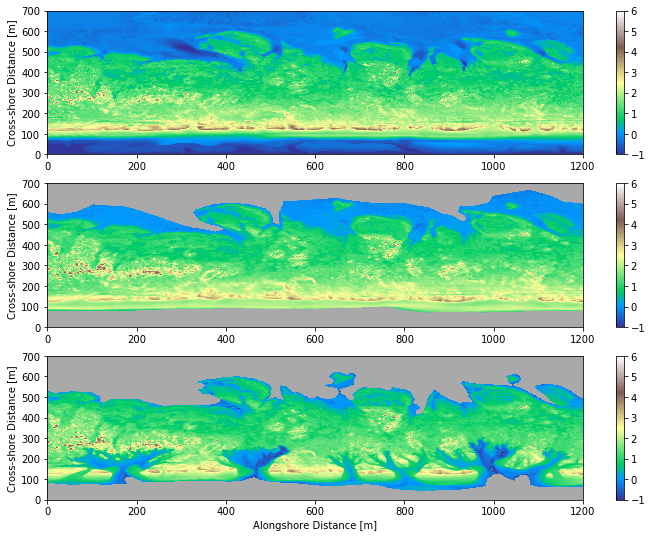

In [53]:
tcmap=plt.cm.terrain
tcmap.set_bad(color='darkgray')
plt.subplots(figsize=(12,9))
for i in range(nf):
    # small plots of elevation
    plt.subplot(3,1,i+1); plt.pcolormesh(dsaa[i,:,:],cmap=tcmap,vmin=-1,vmax=6)
    if(i==2):
        plt.xlabel('Alongshore Distance [m]')
    plt.ylabel('Cross-shore Distance [m]')
    plt.colorbar()

Stats for diffmap:
Shape:  (2, 700, 1200)
mean [ 0.14293298 -0.36005648]
mad [0.23852145 0.40638058]
min [-2.99240847 -3.98986352]
max [2.39974725 1.84966025]
rms [0.34572716 0.71928842]
nans [231817, 315168]
size [840000, 840000]


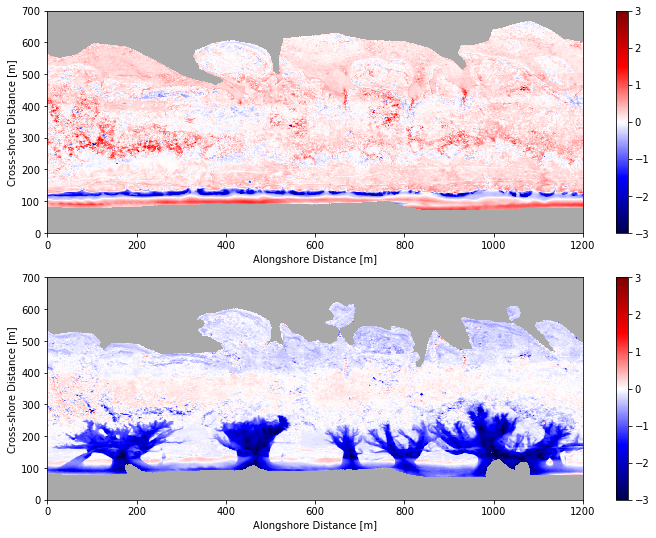

In [51]:
diffmap = np.diff(dsaa,axis=0)
print("Stats for diffmap:")
map_stats(diffmap)
# plot diff maps
dcmap=plt.cm.seismic
dcmap.set_bad(color='darkgray')
    
plt.subplots(figsize=(12,9))
for i in range(2):
    # small plots of elevation
    plt.subplot(2,1,i+1); plt.pcolormesh(diffmap[i,:,:],cmap=dcmap,vmin=-3,vmax=3.)
    plt.ylabel('Cross-shore Distance [m]')
    plt.xlabel('Alongshore Distance [m]')
    plt.colorbar()

In [56]:
np.shape(xu)

(700, 1200)

Text(0.5, 1.0, 'Profiles')

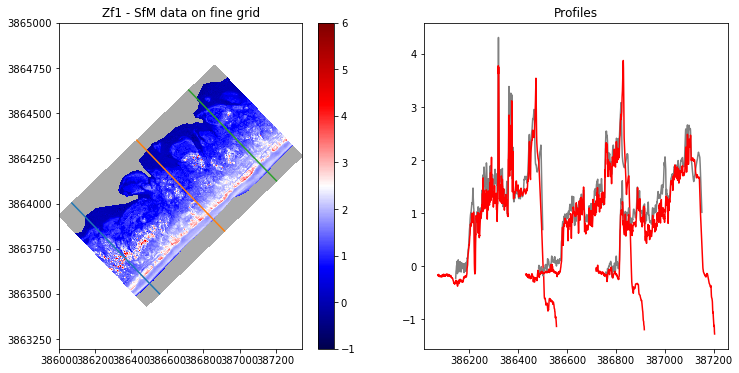

In [62]:
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pcolormesh(xu,yu,dsaa[1,:,:],vmin=-1,vmax=6,cmap=dcmap)
for i in np.array([100,600,1000]):
    plt.plot(xu[:,i],yu[:,i],'-')
plt.title('Zf1 - SfM data on fine grid')
plt.colorbar()
plt.axis('equal');
plt.subplot(1,2,2)
for i in np.array([100,600,1000]):
    plt.plot(xu[:,i],dsaa[1,:,i],'-',color='gray',label='post')
    plt.plot(xu[:,i],dsaa[0,:,i],'-',color='red',label='lidar')

plt.title('Profiles')